In [ ]:
# # !pip install spotipy
# !pip install lightgbm
# !pip install shap
# !pip install player

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
   ---------------------------------------- 0.0/247.3 kB ? eta -:--:--
   ----------------------- ---------------- 143.4/247.3 kB 4.3 MB/s eta 0:00:01
   ---------------------------------------  245.8/247.3 kB 3.0 MB/s eta 0:00:01
   ---------------------------------------- 247.3/247.3 kB 2.5 MB/s eta 0:00:00
   ---------------------------------------- 0.0/43.2 kB ? eta -:--:--
   ---------------------------------------- 43.2/43.2 kB 2.1 MB/s eta 0:00:00
   ---------------------------------------- 0.0/115.4 kB ? eta -:--:--
   ---------------------------------------  112.6/115.4 kB 2.2 MB/s eta 0:00:01
   ---------------------------------------- 115.4/115.4 kB 1.7 MB/s eta 0:00:00
  Created wheel for player: filename=player-0.6.1-py3-none-any.whl size=23060 sha256=f521ac746dfd00d8358f842fbbb6d5ef6fea2e020ef4236bfeda71d008c3d3f2
  Stored in directory: c:\users\jonny\appdata\local\pip\ca

In [3]:
import os
import json
import time
from tqdm import tqdm
import requests
import spotipy
import pandas as pd
import numpy as np
import shap
from scipy.stats import randint, uniform
from scipy.stats import loguniform
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from scipy.stats import mannwhitneyu, f_oneway, shapiro
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, roc_auc_score, classification_report, precision_recall_curve, confusion_matrix, roc_curve
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from dotenv import load_dotenv
from spotipy.oauth2 import SpotifyOAuth
import warnings

In [2]:
warnings.filterwarnings("ignore", category=UserWarning)

In [4]:
# Carrega variáveis do ficheiro .env
load_dotenv()

redirect_uri = os.getenv('SPOTIPY_REDIRECT_URI')
client_id = os.getenv('SPOTIPY_CLIENT_ID')
client_secret = os.getenv('SPOTIPY_CLIENT_SECRET')

# Autenticação com SpotifyOAuth
sp = spotipy.Spotify(auth_manager=SpotifyOAuth(
    client_id=client_id,
    client_secret=client_secret,
    redirect_uri=redirect_uri,
    scope="user-library-read user-read-private"
))

In [6]:
# Function to fetch the track ID
def get_track_id(track_name, artist_name):
    result = sp.search(q=f"track:{track_name} artist:{artist_name}", type="track", limit=1)
    if result['tracks']['items']:
        track_id = result['tracks']['items'][0]['id']
        # print(f"Track ID: {track_id}")
        return track_id
    else:
        # print("Track not found!")
        return None
    

# Function to normalize strings (lowercase and without extra spaces)
def normalize(text):
    return text.lower().strip() if isinstance(text, str) else text
 
 # FEATURE ENGINEERING
def create_features(df):
    df['energy_loudness'] = df['energy'] * df['loudness']
    df['speechiness_loudness'] = df['speechiness'] * df['loudness']
    df['hit_probability'] = df['chorus_hit'] / (df['sections'] + 1)  # Avoid division by zero
    return df

# ADAPTIVE THRESHOLD
def find_best_threshold(model, X_val, y_val):
    probs = model.predict_proba(X_val)[:, 1]
    thresholds = np.linspace(0.3, 0.7, 50)
    best_f1, best_threshold = 0, 0.5
    for t in thresholds:
        preds = (probs >= t).astype(int)
        f1 = f1_score(y_val, preds)
        if f1 > best_f1:
            best_f1, best_threshold = f1, t
    return best_threshold, best_f1


# Data Extraction

In [ ]:
df = pd.read_csv('data/spotify_full_list_20102023.csv', header=0)
df

,Unnamed: 0,Artist and Title,Artist,Streams,Daily,year,main_genre,genres,first_genre,second_genre,third_genre
0,0,J. Cole - No Role Modelz,J. Cole,2300753974,987553,2014.0,Hip-Hop/Rap,"['conscious hip hop', 'hip hop', 'north caroli...",conscious hip hop,hip hop,north carolina hip hop
1,1,Sam Smith - Stay With Me,Sam Smith,2135129240,875392,2014.0,Pop,"['pop', 'uk pop']",pop,uk pop,Unknown
2,2,Mark Ronson - Uptown Funk,Mark Ronson,2039781091,675268,2014.0,Pop,['pop soul'],pop soul,Unknown,Unknown
3,3,Sam Smith - I'm Not The Only One,Sam Smith,1926711475,791299,2014.0,Pop,"['pop', 'uk pop']",pop,uk pop,Unknown
4,4,Maroon 5 - Sugar,Maroon 5,1877824112,552959,2014.0,Pop,['pop'],pop,Unknown,Unknown
...,...,...,...,...,...,...,...,...,...,...,...
10436,21611,iann dior - molly,iann dior,138112487,21049,2019.0,Hip-Hop/Rap,['melodic rap'],melodic rap,Unknown,Unknown
10437,21612,Roddy Ricch - Tip Toe,Roddy Ricch,137996968,10699,2019.0,Hip-Hop/Rap,"['melodic rap', 'rap', 'trap']",melodic rap,rap,trap
10438,21613,Sigrid - Strangers,Sigrid,137925577,15840,2019.0,Pop,"['electropop', 'norwegian pop']",electropop,norwegian pop,Unknown
10439,21614,GAMPER & DADONI - Gimme! Gimme! Gimme!,GAMPER & DADONI,137471196,60612,2019.0,Electronic/Dance,"['german dance', 'pop dance', 'tropical house']",german dance,pop dance,tropical house


In [9]:
df['track_name'].isna
df['track_name'] = df['Artist and Title'].str.split('-', n=1).str[1].fillna(df['Artist and Title'])
df

KeyError: 'track_name'

In [ ]:
# Cache to avoid repeated calls
cache = {}

def get_track_id_batch(names_artists):
    """
    Fetch IDs for a list of (track_name, artist).
    """
    track_ids = []
    for name, artist in names_artists:
        key = (name, artist)
        if key in cache:
            track_ids.append(cache[key])
        else:
            try:
                # Try to get the IDs
                track_id = get_track_id(name, artist)
                cache[key] = track_id
                track_ids.append(track_id)
            except Exception as e:
                track_ids.append(None)
                # print(f"Error fetching ID for {name} - {artist}: {e}")
            time.sleep(0.1)  # Pause to respect request limits
    return track_ids

# Divide the dataframe into batches
batch_size = 50
batches = [df.iloc[i:i + batch_size] for i in range(0, len(df), batch_size)]

# Iterate through the batches
for batch in tqdm(batches):
    names_artists = list(zip(batch['track_name'], batch['Artist']))
    batch['track_id'] = get_track_id_batch(names_artists)

df_final = pd.concat(batches, ignore_index=True)


  0%|          | 0/209 [00:00<?, ?it/s]C:\Users\Jonny\AppData\Local\Temp\ipykernel_36692\3487910097.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['track_id'] = get_track_id_batch(names_artists)
  0%|          | 1/209 [00:10<36:59, 10.67s/it]C:\Users\Jonny\AppData\Local\Temp\ipykernel_36692\3487910097.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['track_id'] = get_track_id_batch(names_artists)
  1%|          | 2/209 [00:21<36:16, 10.52s/it]C:\Users\Jonny\AppData\Local\Temp\ipykernel

In [ ]:
save_path_pickle = "data/tracks_with_ids.pkl"
df_final.to_pickle(save_path_pickle)
df_final.to_csv('data/tracks_with_ids.csv')

# Data processing

In [7]:
df_enriched2 = pd.read_csv('data/audio_features.csv', header=0)
df_enriched2.rename({'performer' : 'artist', 'song' : 'track'}, axis='columns', inplace = True)
df_enriched2.drop(['song_id','spotify_track_preview_url', 'spotify_track_explicit', 'spotify_track_album'], axis=1, inplace = True)
df_enriched2.dropna(thresh=7, inplace=True)
df_enriched2

,artist,track,spotify_genre,spotify_track_id,spotify_track_duration_ms,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,spotify_track_popularity
2,Andy Williams,......And Roses And Roses,"['adult standards', 'brill building pop', 'eas...",3tvqPPpXyIgKrm4PR9HCf0,166106.0,0.154,0.185,5.0,-14.063,1.0,0.0315,0.91100,0.000267,0.1120,0.150,83.969,4.0,38.0
3,Sandy Nelson,...And Then There Were Drums,"['rock-and-roll', 'space age pop', 'surf music']",1fHHq3qHU8wpRKHzhojZ4a,172066.0,0.588,0.672,11.0,-17.278,0.0,0.0361,0.00256,0.745000,0.1450,0.801,121.962,4.0,11.0
4,Britney Spears,...Baby One More Time,"['dance pop', 'pop', 'post-teen pop']",3MjUtNVVq3C8Fn0MP3zhXa,211066.0,0.759,0.699,0.0,-5.745,0.0,0.0307,0.20200,0.000131,0.4430,0.907,92.960,4.0,77.0
5,Taylor Swift,...Ready For It?,"['pop', 'post-teen pop']",2yLa0QULdQr0qAIvVwN6B5,208186.0,0.613,0.764,2.0,-6.509,1.0,0.1360,0.05270,0.000000,0.1970,0.417,160.015,4.0,73.0
7,Paul Davis,'65 Love Affair,"['album rock', 'bubblegum pop', 'country rock'...",5nBp8F6tekSrnFg8G2Pvug,219813.0,0.647,0.686,2.0,-4.247,0.0,0.0274,0.43200,0.000006,0.1330,0.952,155.697,4.0,40.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29495,The Five Americans,Zip Code,"['bubblegum pop', 'classic garage rock', 'frea...",7hTW791CEdFSlw2wouCVYP,175040.0,0.393,0.594,9.0,-5.986,1.0,0.0267,0.03940,0.000000,0.0479,0.927,139.535,4.0,5.0
29497,Bad Wolves,Zombie,"['alternative metal', 'metal', 'post-grunge']",1vNoA9F5ASnlBISFekDmg3,254805.0,0.448,0.826,2.0,-3.244,0.0,0.0319,0.00756,0.000000,0.1170,0.190,77.093,4.0,74.0
29499,Future,Zoom,"['atl hip hop', 'hip hop', 'pop rap', 'rap', '...",2IG6Te7JyvrtqhFeOF7le4,278429.0,0.852,0.438,9.0,-7.673,1.0,0.4260,0.01450,0.000000,0.2630,0.627,150.945,4.0,51.0
29501,Herb Alpert & The Tijuana Brass,Zorba The Greek,"['adult standards', 'easy listening', 'lounge']",3WLEVNohakzZmMpN5W7mHK,264853.0,0.531,0.642,5.0,-12.702,1.0,0.3230,0.15400,0.279000,0.0584,0.192,82.107,4.0,35.0


In [8]:
df_enriched = pd.read_csv('data/tracks_with_ids.csv', header=0)
df_enriched.drop(['Unnamed: 0.1', 'Unnamed: 0'], axis=1, inplace = True)
df_enriched

,Artist and Title,Artist,Streams,Daily,year,main_genre,genres,first_genre,second_genre,third_genre,track_name,track_id
0,J. Cole - No Role Modelz,J. Cole,2300753974,987553,2014.0,Hip-Hop/Rap,"['conscious hip hop', 'hip hop', 'north caroli...",conscious hip hop,hip hop,north carolina hip hop,No Role Modelz,NaN
1,Sam Smith - Stay With Me,Sam Smith,2135129240,875392,2014.0,Pop,"['pop', 'uk pop']",pop,uk pop,Unknown,Stay With Me,NaN
2,Mark Ronson - Uptown Funk,Mark Ronson,2039781091,675268,2014.0,Pop,['pop soul'],pop soul,Unknown,Unknown,Uptown Funk,NaN
3,Sam Smith - I'm Not The Only One,Sam Smith,1926711475,791299,2014.0,Pop,"['pop', 'uk pop']",pop,uk pop,Unknown,I'm Not The Only One,1G5H6Dh8AmuUZY7abHcYMH
4,Maroon 5 - Sugar,Maroon 5,1877824112,552959,2014.0,Pop,['pop'],pop,Unknown,Unknown,Sugar,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
10436,iann dior - molly,iann dior,138112487,21049,2019.0,Hip-Hop/Rap,['melodic rap'],melodic rap,Unknown,Unknown,molly,NaN
10437,Roddy Ricch - Tip Toe,Roddy Ricch,137996968,10699,2019.0,Hip-Hop/Rap,"['melodic rap', 'rap', 'trap']",melodic rap,rap,trap,Tip Toe,6NbXfStqkrYH8z1QMsfJr0
10438,Sigrid - Strangers,Sigrid,137925577,15840,2019.0,Pop,"['electropop', 'norwegian pop']",electropop,norwegian pop,Unknown,Strangers,NaN
10439,GAMPER & DADONI - Gimme! Gimme! Gimme!,GAMPER & DADONI,137471196,60612,2019.0,Electronic/Dance,"['german dance', 'pop dance', 'tropical house']",german dance,pop dance,tropical house,Gimme! Gimme! Gimme!,NaN


In [9]:
# Path to the folder containing the CSV files
folder = "features"

# List to store all DataFrames
dfs = []

# Iterate through all CSV files in the folder
for filename in os.listdir(folder):
    if filename.endswith(".csv"):  # Ensures only CSV files are read
        file_path = os.path.join(folder, filename)
        df = pd.read_csv(file_path)

        # Normalize column names to avoid inconsistencies
        df.columns = [col.lower().strip() for col in df.columns]

        # Normalize artist and track names to facilitate merging
        if 'artist' in df.columns and 'track' in df.columns:
            df['artist_norm'] = df['artist'].apply(normalize)
            df['track_norm'] = df['track'].apply(normalize)
            dfs.append(df)
        # else:
        #     print(f"Warning: {filename} does not contain the required columns.")

# Combine all datasets (row-wise concatenation)
if len(dfs) > 0:
    df_features = pd.concat(dfs, ignore_index=True)

df_features.rename({'artist': 'Artist'}, axis='columns', inplace=True)


In [10]:
df_enriched2

,artist,track,spotify_genre,spotify_track_id,spotify_track_duration_ms,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,spotify_track_popularity
2,Andy Williams,......And Roses And Roses,"['adult standards', 'brill building pop', 'eas...",3tvqPPpXyIgKrm4PR9HCf0,166106.0,0.154,0.185,5.0,-14.063,1.0,0.0315,0.91100,0.000267,0.1120,0.150,83.969,4.0,38.0
3,Sandy Nelson,...And Then There Were Drums,"['rock-and-roll', 'space age pop', 'surf music']",1fHHq3qHU8wpRKHzhojZ4a,172066.0,0.588,0.672,11.0,-17.278,0.0,0.0361,0.00256,0.745000,0.1450,0.801,121.962,4.0,11.0
4,Britney Spears,...Baby One More Time,"['dance pop', 'pop', 'post-teen pop']",3MjUtNVVq3C8Fn0MP3zhXa,211066.0,0.759,0.699,0.0,-5.745,0.0,0.0307,0.20200,0.000131,0.4430,0.907,92.960,4.0,77.0
5,Taylor Swift,...Ready For It?,"['pop', 'post-teen pop']",2yLa0QULdQr0qAIvVwN6B5,208186.0,0.613,0.764,2.0,-6.509,1.0,0.1360,0.05270,0.000000,0.1970,0.417,160.015,4.0,73.0
7,Paul Davis,'65 Love Affair,"['album rock', 'bubblegum pop', 'country rock'...",5nBp8F6tekSrnFg8G2Pvug,219813.0,0.647,0.686,2.0,-4.247,0.0,0.0274,0.43200,0.000006,0.1330,0.952,155.697,4.0,40.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29495,The Five Americans,Zip Code,"['bubblegum pop', 'classic garage rock', 'frea...",7hTW791CEdFSlw2wouCVYP,175040.0,0.393,0.594,9.0,-5.986,1.0,0.0267,0.03940,0.000000,0.0479,0.927,139.535,4.0,5.0
29497,Bad Wolves,Zombie,"['alternative metal', 'metal', 'post-grunge']",1vNoA9F5ASnlBISFekDmg3,254805.0,0.448,0.826,2.0,-3.244,0.0,0.0319,0.00756,0.000000,0.1170,0.190,77.093,4.0,74.0
29499,Future,Zoom,"['atl hip hop', 'hip hop', 'pop rap', 'rap', '...",2IG6Te7JyvrtqhFeOF7le4,278429.0,0.852,0.438,9.0,-7.673,1.0,0.4260,0.01450,0.000000,0.2630,0.627,150.945,4.0,51.0
29501,Herb Alpert & The Tijuana Brass,Zorba The Greek,"['adult standards', 'easy listening', 'lounge']",3WLEVNohakzZmMpN5W7mHK,264853.0,0.531,0.642,5.0,-12.702,1.0,0.3230,0.15400,0.279000,0.0584,0.192,82.107,4.0,35.0


In [31]:
# Normalize artist and track names in both datasets
df_features['artist_norm'] = df_features['Artist'].apply(normalize)
df_features['track_norm']  = df_features['track'].apply(normalize)

df_enriched['artist_norm'] = df_enriched['Artist'].apply(normalize)
df_enriched['track_norm']  = df_enriched['track_name'].apply(normalize)

df_enriched2['artist_norm'] = df_enriched2['artist'].apply(normalize)
df_enriched2['track_norm']  = df_enriched2['track'].apply(normalize)


print("Original records df_features:", len(df_features))
print("Original records df_enriched:", len(df_enriched))
print("Original records df_enriched2:", len(df_enriched2))

# Remove duplicates – adjusting for the columns that define a unique track
df_features.drop_duplicates(subset=['Artist', 'track'], inplace=True)
df_enriched.drop_duplicates(subset=['Artist', 'track_name'], inplace=True)
df_enriched2.drop_duplicates(subset=['artist', 'track'], inplace=True)

print("After removing duplicates df_features:", len(df_features))
print("After removing duplicates df_enriched:", len(df_enriched))
print("After removing duplicates df_enriched2:", len(df_enriched2))

# Create a set of tuples (artist_norm, track_norm) for the TOP100 tracks
top100_set = set(zip(df_enriched['artist_norm'], df_enriched['track_norm']))
top100_set2 = set(zip(df_enriched2['artist_norm'], df_enriched2['track_norm']))

top100_combined = top100_set.union(top100_set2)

# Create a new 'in_top100' column in df_features:
# 1 if the track is in the TOP100 list, 0 otherwise
df_features['in_top100'] = df_features.apply(
    lambda row: 1 if (row['artist_norm'], row['track_norm']) in top100_combined else 0, 
    axis=1
)

print(len(df_features.loc[df_features['in_top100'] == 1]))


# Optional: Remove auxiliary normalization columns if desired
df_features.drop(columns=['target','artist_norm', 'track_norm'], inplace=True)


print("Merge completed! The final dataset has the 'in_top100' column.")


Original records df_features: 40003
Original records df_enriched: 10238
Original records df_enriched2: 24224
After removing duplicates df_features: 40003
After removing duplicates df_enriched: 10238
After removing duplicates df_enriched2: 24224
19436
Merge completed! The final dataset has the 'in_top100' column.


In [33]:
df_features.loc[df_features['in_top100']==1]

,track,Artist,uri,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,chorus_hit,sections,in_top100
0,Lucky Man,Montgomery Gentry,spotify:track:4GiXBCUF7H6YfNQsnBRIzl,0.578,0.471,4,-7.270,1,0.0289,0.36800,0.000000,0.1590,0.532,133.061,196707,4,30.88059,13,1
1,On The Hotline,Pretty Ricky,spotify:track:1zyqZONW985Cs4osz9wlsu,0.704,0.854,10,-5.477,0,0.1830,0.01850,0.000000,0.1480,0.688,92.988,242587,4,41.51106,10,1
4,I Got A Feelin',Billy Currington,spotify:track:1tF370eYXUcWwkIvaq3IGz,0.630,0.764,2,-4.353,1,0.0275,0.36300,0.000000,0.1250,0.631,112.098,193760,4,22.62384,10,1
7,Where I Come From,Alan Jackson,spotify:track:6ej1QJ8eIYmhsyTlvgDajy,0.726,0.631,11,-8.136,0,0.0334,0.22000,0.000000,0.1930,0.746,124.711,239240,4,35.59732,10,1
8,Nothin' To Die For,Tim McGraw,spotify:track:3lRSz6HujrSy9b3LXg2Kq9,0.481,0.786,10,-5.654,1,0.0288,0.05380,0.000000,0.0759,0.389,153.105,253640,4,19.65701,11,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41098,Love Like This,Faith Evans,spotify:track:7MQywXGHEev7JmwwIzMcao,0.767,0.551,0,-7.328,1,0.0616,0.00364,0.000000,0.0451,0.796,100.904,275707,4,32.35991,11,1
41099,"No Guns, No Murder",Rayvon,spotify:track:54zbUGqw8JRk020wLRWlHl,0.797,0.683,10,-14.299,0,0.2190,0.08160,0.000000,0.2960,0.885,97.984,277027,4,28.96569,15,1
41100,Deeper,Boss,spotify:track:6PZ4laM20qkvIrgji3NLsK,0.631,0.848,6,-6.435,0,0.3380,0.05500,0.000000,0.3850,0.679,83.155,241560,4,22.23523,13,1
41103,Good Times,Edie Brickell,spotify:track:6UPfnVoOq3y3BvapBIKs8J,0.562,0.314,10,-15.213,0,0.0298,0.44000,0.000011,0.1060,0.571,166.847,189827,4,21.11763,10,1


In [34]:
# -----------------------------
# 2. Define Features for Analysis
# -----------------------------
features = [
    'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
    'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
    'duration_ms', 'time_signature', 'chorus_hit', 'sections'
]

In [35]:
# -----------------------------
# 3. Separate Data into TOP and non-TOP Groups
# -----------------------------
# Assuming 'in_top100' is 1 for TOP songs and 0 for non-TOP songs

df_top = df_features[df_features['in_top100'] == 1]
df_non_top = df_features[df_features['in_top100'] == 0]

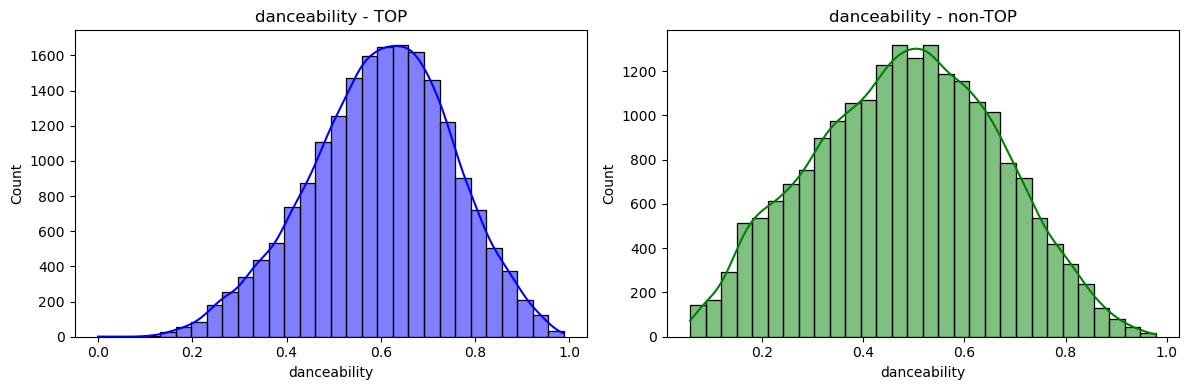

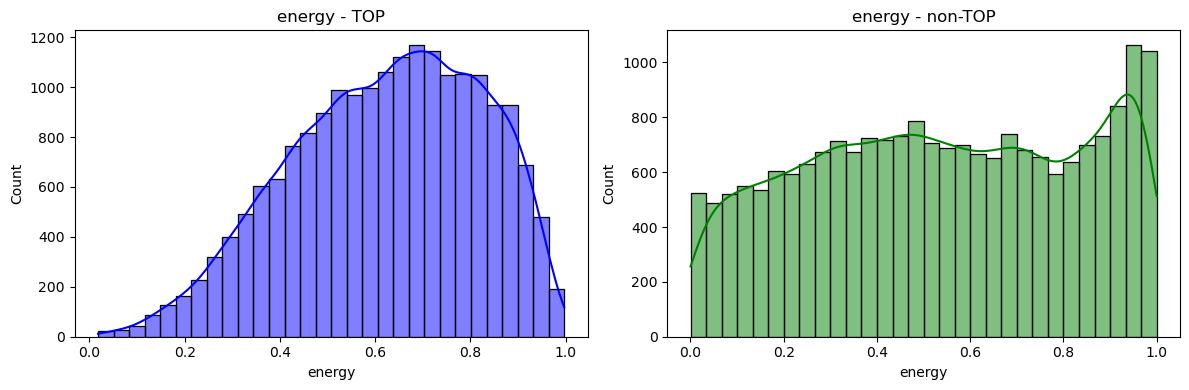

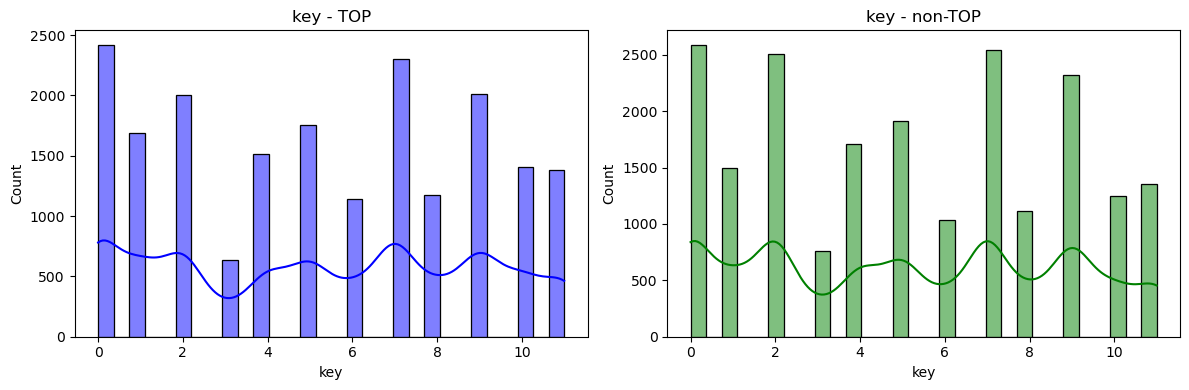

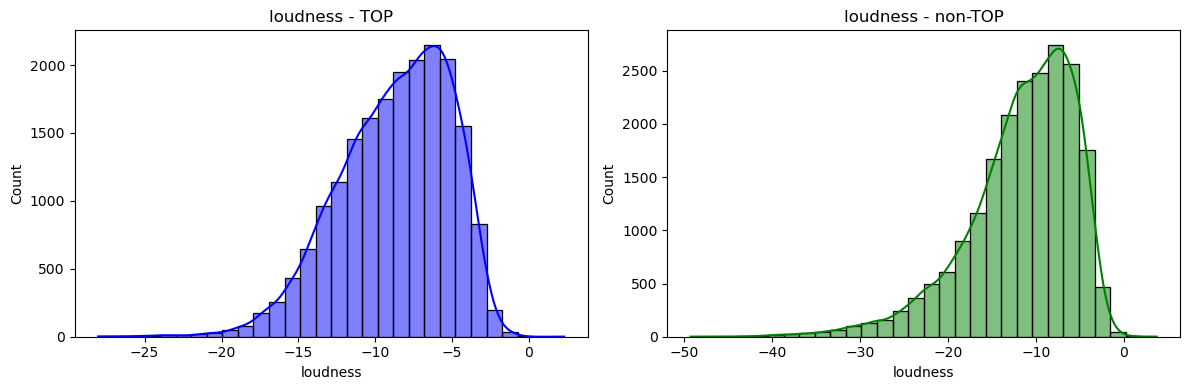

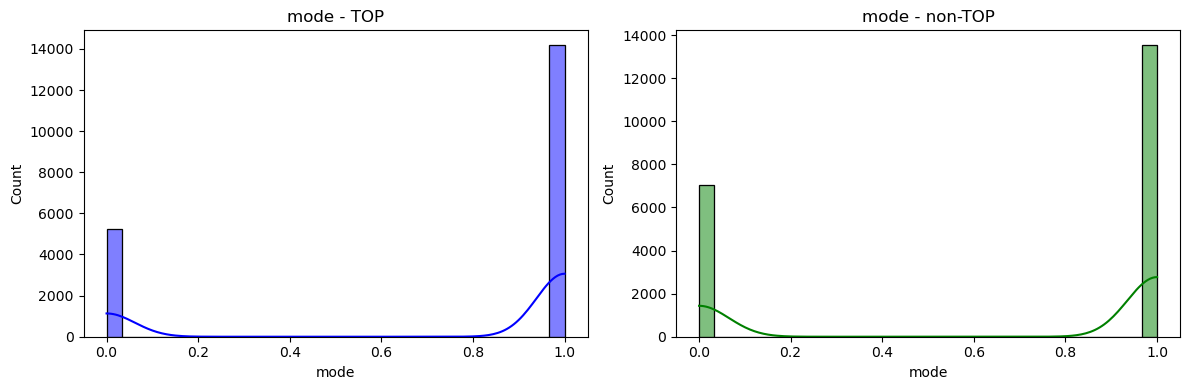

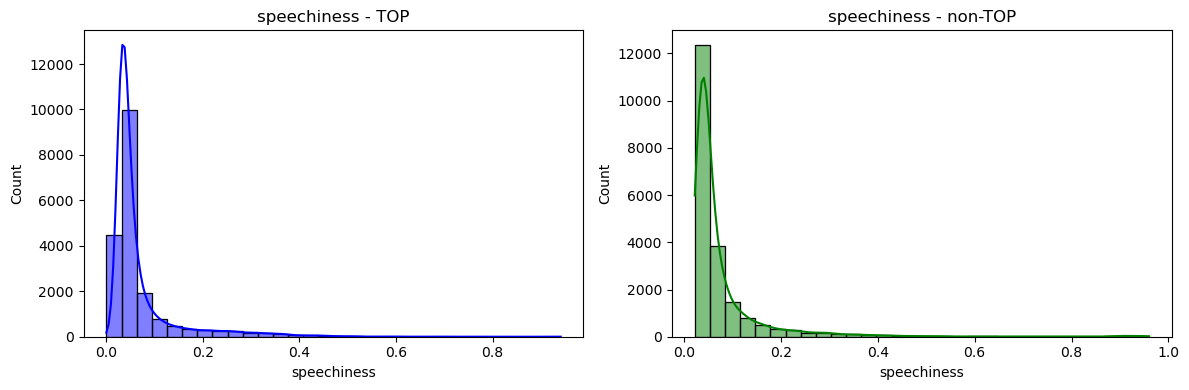

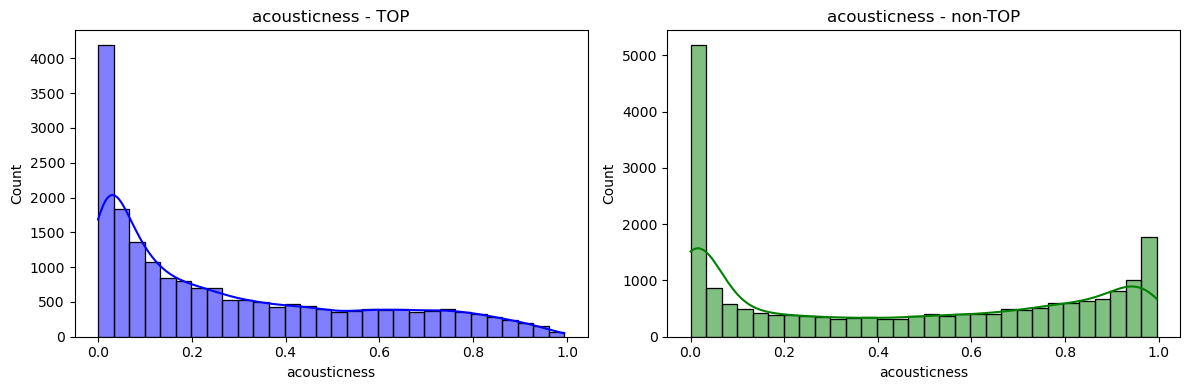

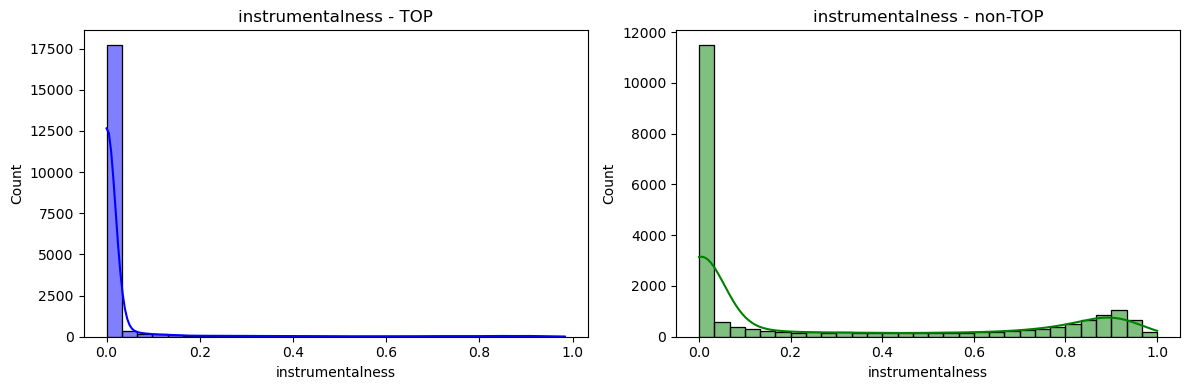

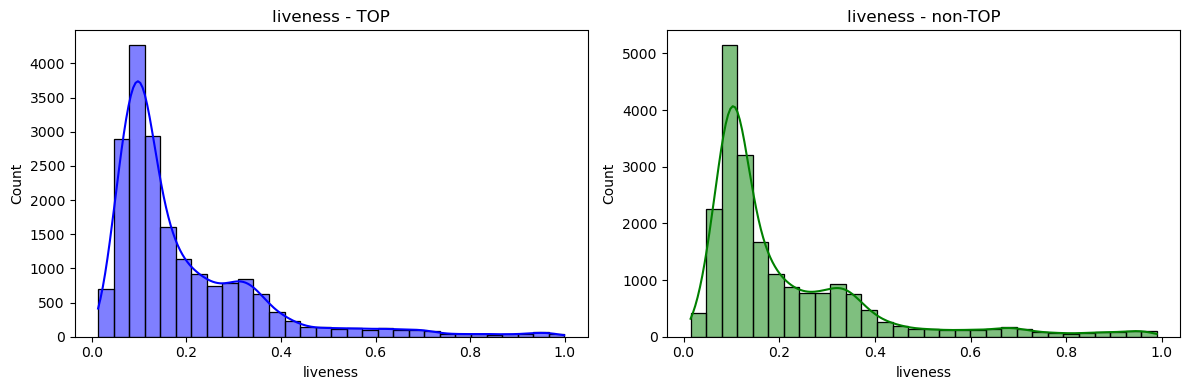

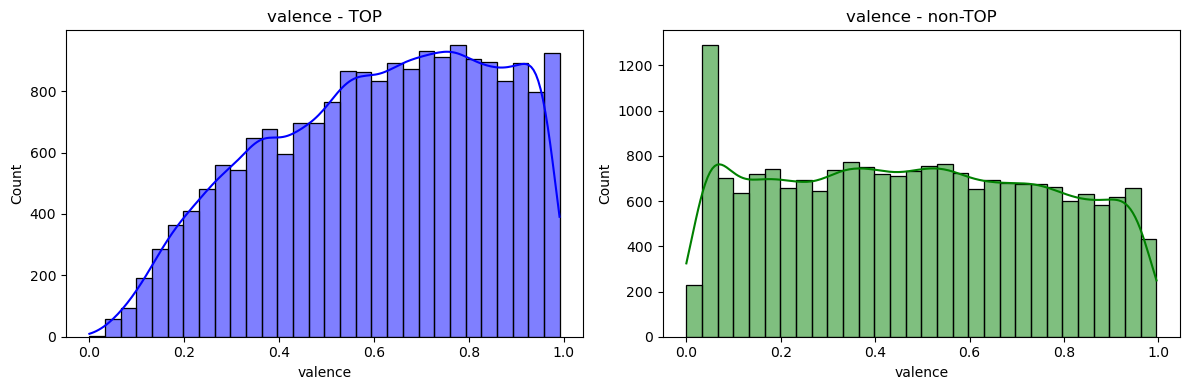

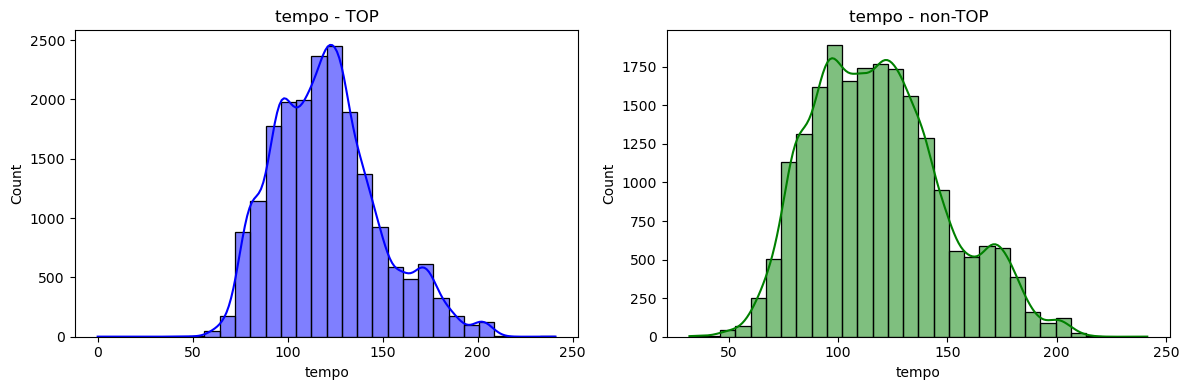

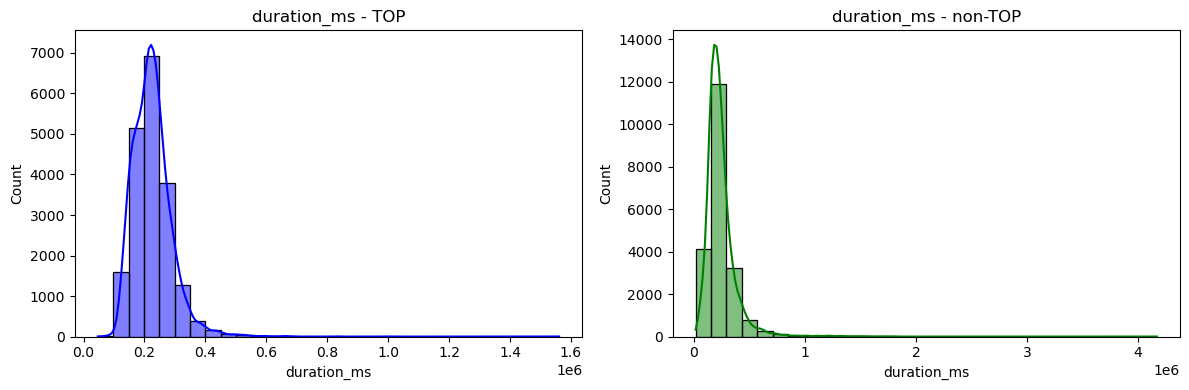

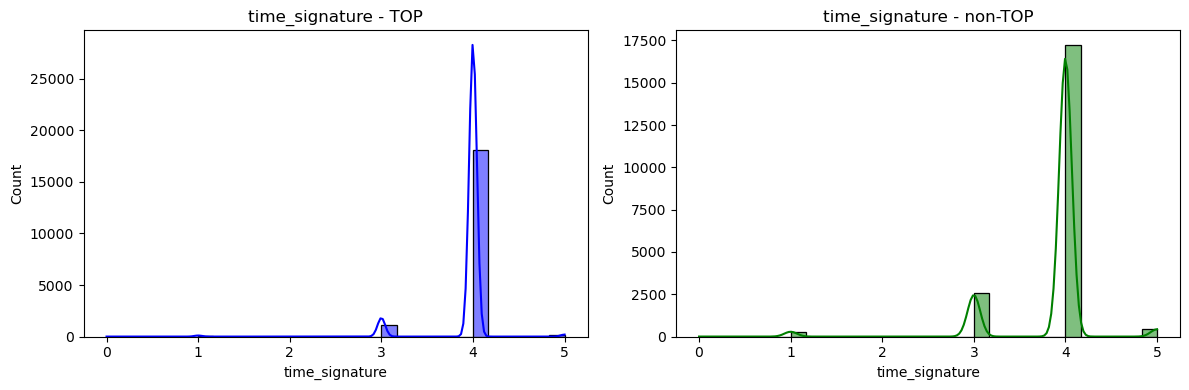

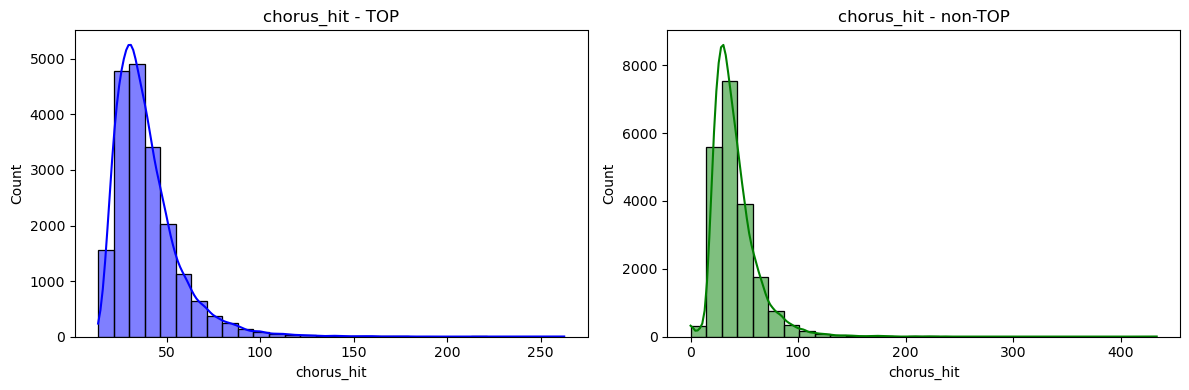

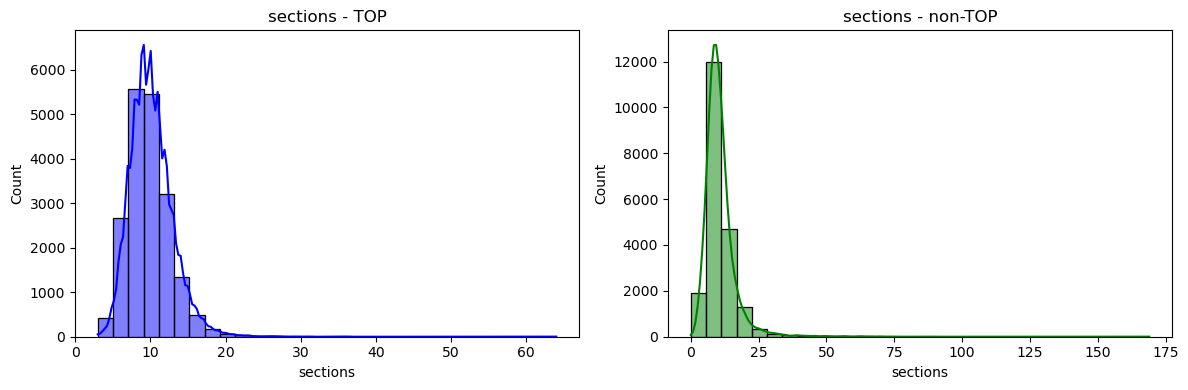

In [18]:
# -----------------------------
# 4. Plot Histograms for Each Feature (Separate for TOP and non-TOP)
# -----------------------------
for feature in features:
    # Create subplots with independent y-axis scales
    fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=False)
    
    sns.histplot(data=df_top, x=feature, bins=30, kde=True, ax=axes[0], color='blue')
    axes[0].set_title(f"{feature} - TOP")
    axes[0].set_xlabel(feature)
    
    sns.histplot(data=df_non_top, x=feature, bins=30, kde=True, ax=axes[1], color='green')
    axes[1].set_title(f"{feature} - non-TOP")
    axes[1].set_xlabel(feature)
    
    plt.tight_layout()
    # plt.savefig(f"hist_{feature}.png")
    plt.show()

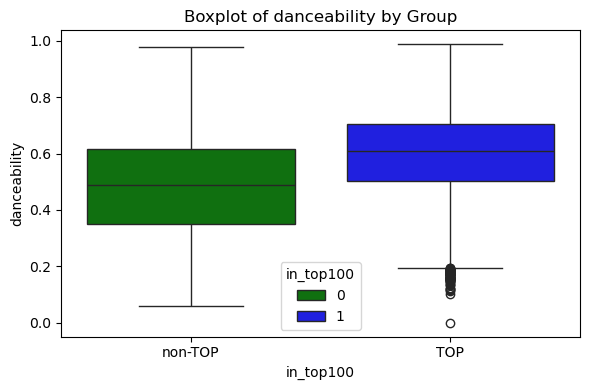

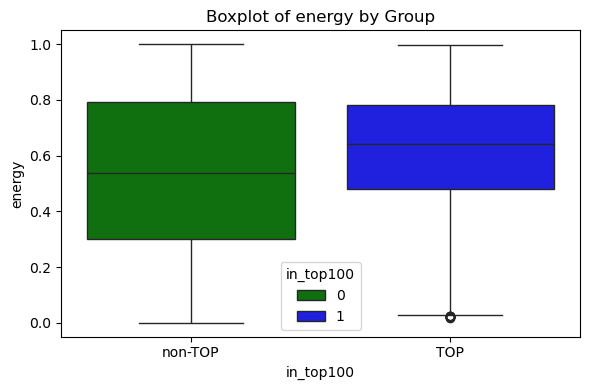

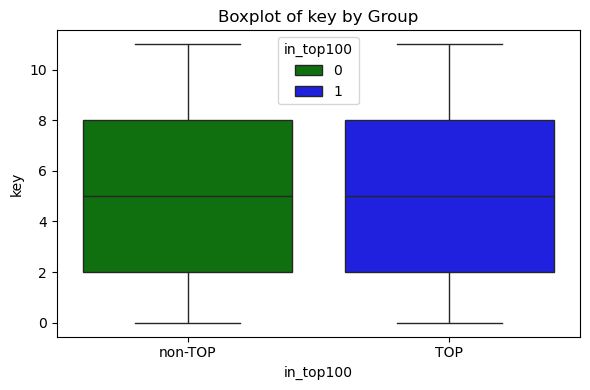

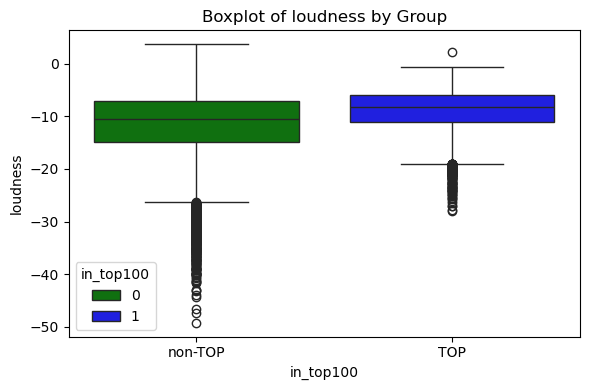

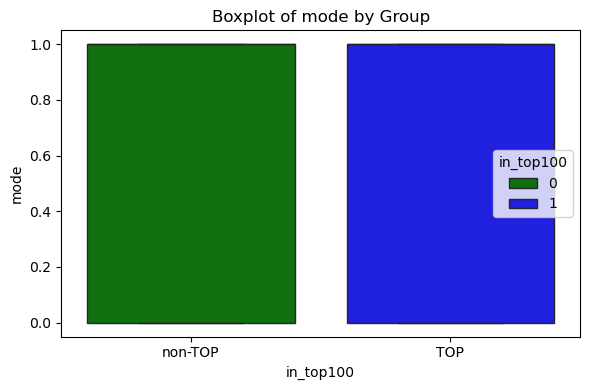

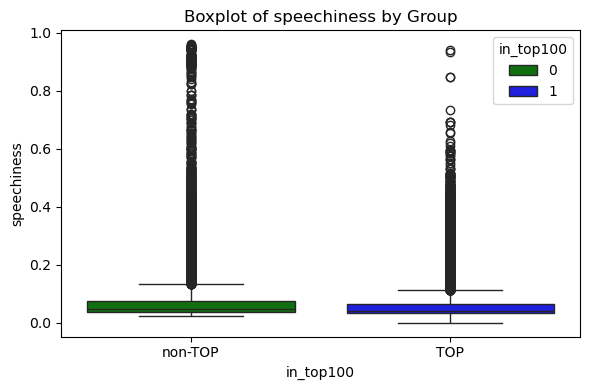

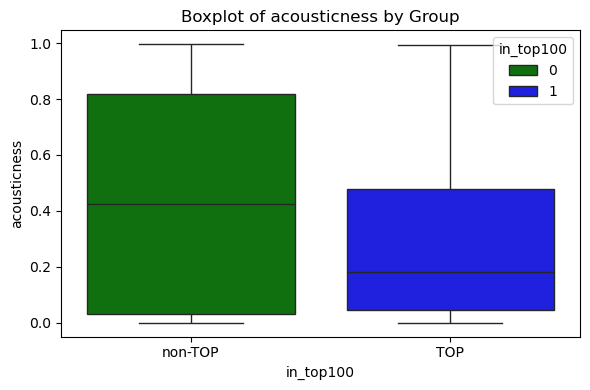

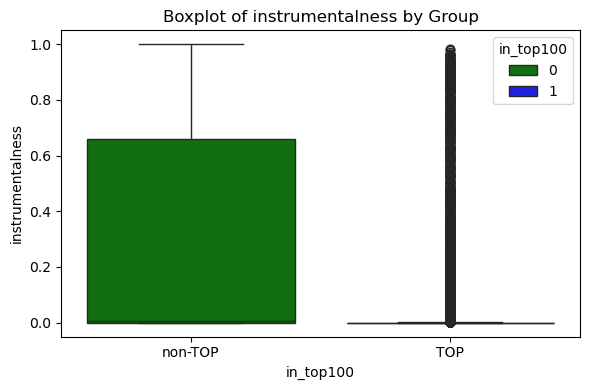

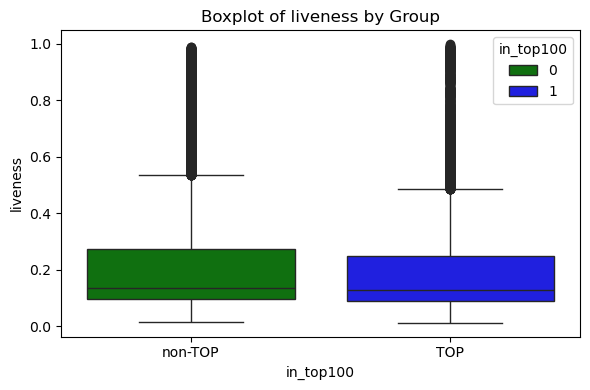

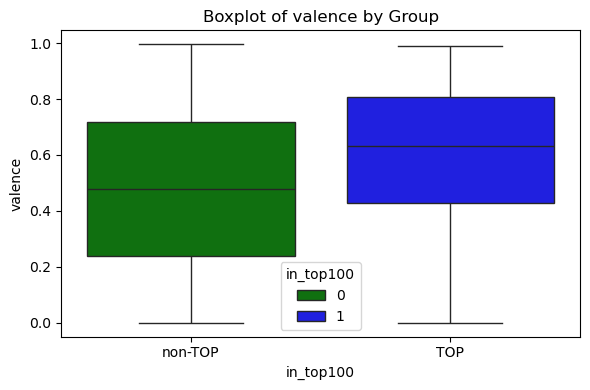

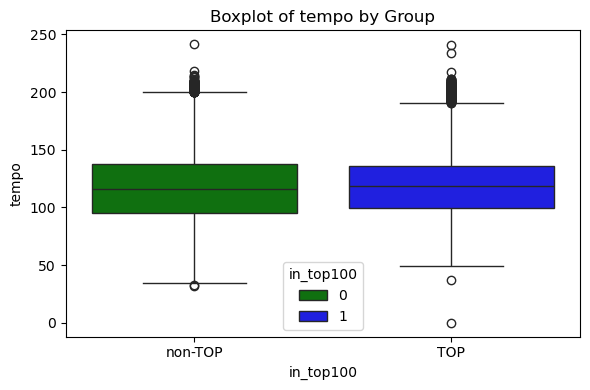

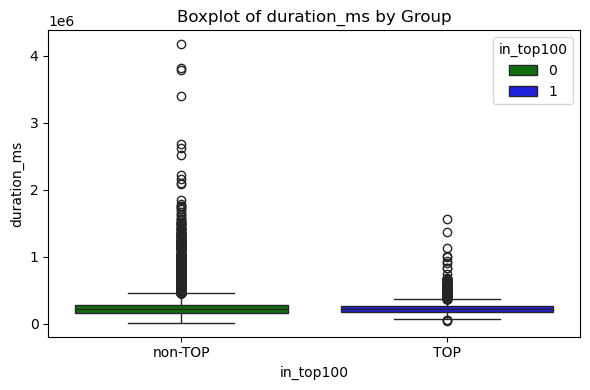

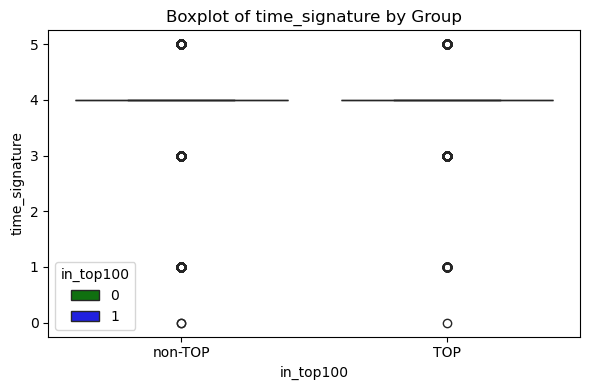

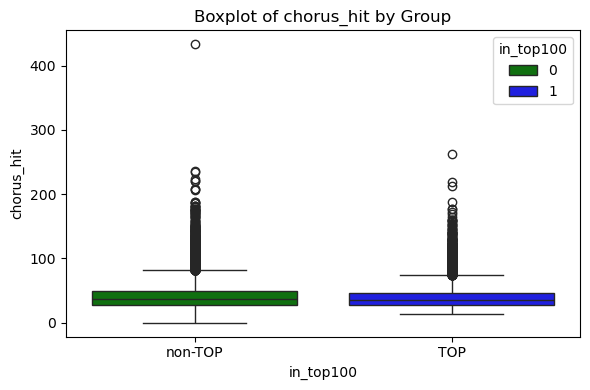

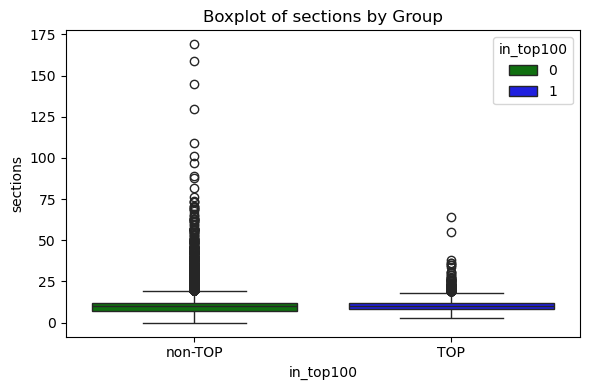

In [19]:
# -----------------------------
# 5. Plot Boxplots for Each Feature by Group
# -----------------------------
for feature in features:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x='in_top100', y=feature, data=df_features, hue = 'in_top100', legend = 'auto', palette=["green", "blue"])
    plt.title(f"Boxplot of {feature} by Group")
    plt.xticks([0, 1], ["non-TOP", "TOP"])
    plt.tight_layout()
    # plt.savefig(f"boxplot_{feature}.png")
    plt.show()

In [69]:
# -----------------------------
# 6. Descriptive Statistics by Group
# -----------------------------
# Compute descriptive statistics grouped by 'in_top100'
stats_by_group = df_features.groupby('in_top100')[features].describe().transpose()

# Set display options to show all columns and rows
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)

print("Descriptive Statistics by Group:")
print(stats_by_group)

# Save the descriptive statistics to a CSV file
# stats_by_group.to_csv("descriptive_statistics_by_group_full.csv", index=True)

Descriptive Statistics by Group:
in_top100                          0             1
danceability     count  2.056700e+04  1.943600e+04
                 mean   4.833492e-01  6.000795e-01
                 std    1.819952e-01  1.510981e-01
                 min    5.760000e-02  0.000000e+00
                 25%    3.500000e-01  5.010000e-01
                 50%    4.880000e-01  6.080000e-01
                 75%    6.160000e-01  7.060000e-01
                 max    9.780000e-01  9.880000e-01
energy           count  2.056700e+04  1.943600e+04
                 mean   5.380601e-01  6.230227e-01
                 std    2.877757e-01  1.989796e-01
                 min    2.510000e-04  1.810000e-02
                 25%    3.010000e-01  4.800000e-01
                 50%    5.390000e-01  6.410000e-01
                 75%    7.930000e-01  7.830000e-01
                 max    1.000000e+00  9.970000e-01
key              count  2.056700e+04  1.943600e+04
                 mean   5.163417e+00  5.254939e+0

In [70]:
pd.reset_option('display.max_columns')
pd.reset_option('display.max_rows')
pd.reset_option('display.width')

In [36]:
# -----------------------------
# 7. Statistical Tests: Mann-Whitney U Test for Each Feature
# -----------------------------
p_values = {}
for feature in features:
    top_data = df_top[feature].dropna()
    non_top_data = df_non_top[feature].dropna()
    stat, p = mannwhitneyu(top_data, non_top_data, alternative='two-sided')
    p_values[feature] = p

p_values_df = pd.DataFrame(list(p_values.items()), columns=['Feature', 'p_value'])
print("Mann-Whitney U test p-values:")
print(p_values_df)
# p_values_df.to_csv("mann_whitney_pvalues.csv", index=False)

Mann-Whitney U test p-values:
             Feature        p_value
0       danceability   0.000000e+00
1             energy  3.370539e-174
2                key   1.316633e-02
3           loudness   0.000000e+00
4               mode   1.672077e-54
5        speechiness  1.742649e-164
6       acousticness  4.511002e-229
7   instrumentalness   0.000000e+00
8           liveness   1.277135e-29
9            valence   0.000000e+00
10             tempo   1.611468e-14
11       duration_ms   1.840331e-03
12    time_signature   1.434708e-83
13        chorus_hit   2.099487e-09
14          sections   4.764876e-04


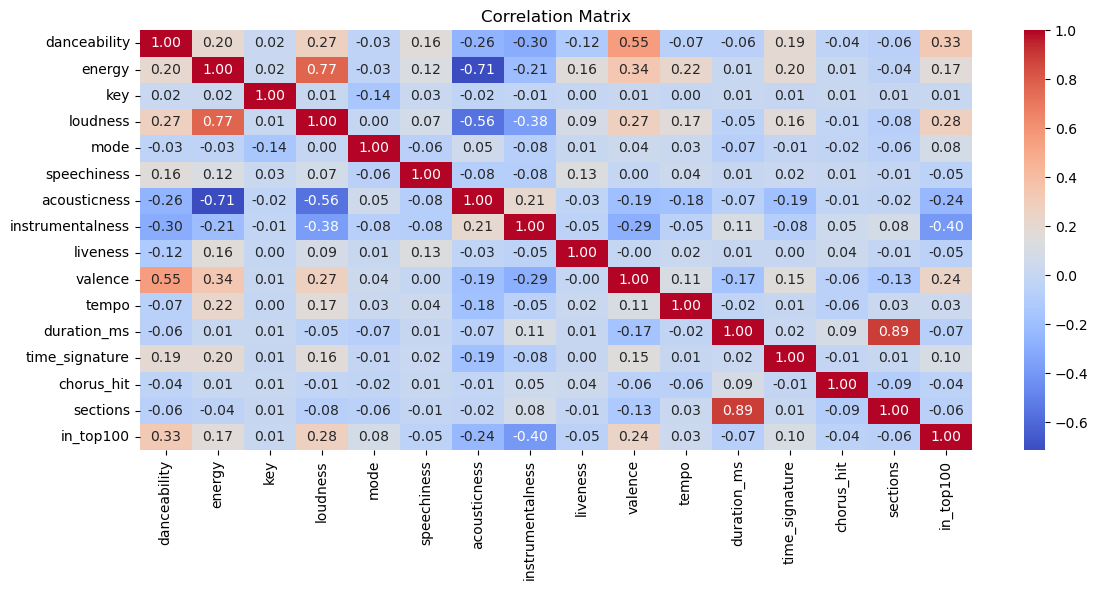

In [37]:
# -----------------------------
# 8. Correlation Matrix Plot
# -----------------------------
plt.figure(figsize=(12, 6))
corr_matrix = df_features[features + ['in_top100']].corr()
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.tight_layout()
# plt.savefig("correlation_matrix.png")
plt.show()

In [38]:
## anova analysis ##
anova_results = {}
for feature in features:
    f_stat, p_val = f_oneway(df_top[feature], df_non_top[feature])
    anova_results[feature] = p_val

# Display the results
anova_results_df = pd.DataFrame(list(anova_results.items()), columns=['Feature', 'p-value'])
anova_results_df


,Feature,p-value
0,danceability,0.000000e+00
1,energy,4.005049e-252
2,key,9.639218e-03
3,loudness,0.000000e+00
4,mode,1.162452e-54
5,speechiness,5.197717e-24
6,acousticness,0.000000e+00
7,instrumentalness,0.000000e+00
8,liveness,3.932030e-26
9,valence,0.000000e+00


In [39]:
## shapiro analysis ##
normality_results = {}
for feature in features:
    stat, p_val = shapiro(df_features[feature])
    normality_results[feature] = p_val

# Display the results
normality_results_df = pd.DataFrame(list(normality_results.items()), columns=['Feature', 'p-value'])
normality_results_df

,Feature,p-value
0,danceability,8.679475e-43
1,energy,1.975241e-65
2,key,2.179811e-83
3,loudness,1.434093e-89
4,mode,1.898698e-130
5,speechiness,9.713069e-135
6,acousticness,2.732368e-98
7,instrumentalness,3.002858e-132
8,liveness,8.667660e-115
9,valence,4.773442e-70


In [23]:
# Select the numeric features
X = df_features[features]
X = add_constant(X)  # Add a constant for the model

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Display the VIF
vif_data


,Feature,VIF
0,const,194.064044
1,danceability,1.808086
2,energy,4.285304
3,key,1.021606
4,loudness,2.962537
5,mode,1.042625
6,speechiness,1.095898
7,acousticness,2.253401
8,instrumentalness,1.314213
9,liveness,1.088583


# Model Testing

In [49]:
# Assuming 'df' is the DataFrame with the features and the 'TOP_spotify' column
X = df_features.drop(columns=['track','Artist','uri', 'in_top100'])
y = df_features['in_top100']

# Scaling the numeric variables
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Splitting the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


# Balancing with SMOTE
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# 3 Feature Engineering - Create new features based on interactions
X_train_res['energy_loudness'] = X_train_res['energy'] * X_train_res['loudness']
X_train['energy_loudness'] = X_train['energy'] * X_train['loudness']
X_test['energy_loudness'] = X_test['energy'] * X_test['loudness']


In [47]:
X_test

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,chorus_hit,sections,energy_loudness
38796,0.845,0.163,2,-13.785,1,0.0506,0.845000,0.00242,0.1220,0.460,98.161,152076,4,48.27016,7,-2.246955
14457,0.341,0.319,0,-16.715,1,0.0358,0.719000,0.00000,0.2000,0.452,73.760,138547,5,23.54575,7,-5.332085
8066,0.962,0.573,7,-5.924,1,0.3080,0.016100,0.00000,0.1090,0.728,125.035,237655,4,61.96648,7,-3.394452
12405,0.420,0.483,1,-13.608,1,0.0330,0.165000,0.00000,0.1110,0.533,93.834,167027,4,36.89252,7,-6.572664
27483,0.614,0.463,2,-11.246,0,0.0292,0.328000,0.89400,0.0824,0.810,132.408,148627,4,65.35702,6,-5.206898
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3799,0.644,0.725,11,-4.622,1,0.0701,0.011200,0.00000,0.1460,0.584,77.977,222053,4,46.34699,9,-3.350950
12259,0.565,0.805,0,-4.457,1,0.0489,0.080800,0.00000,0.1730,0.869,76.040,181933,4,38.94659,7,-3.587885
36552,0.699,0.577,6,-12.375,1,0.1720,0.002430,0.02680,0.0581,0.802,177.213,295067,4,31.77604,15,-7.140375
483,0.691,0.366,6,-7.565,1,0.0280,0.565000,0.00000,0.1270,0.278,88.782,217667,4,42.75747,10,-2.768790


In [41]:
# Initializing models
models = {
    "Logistic Regression": LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000),
    "Random Forest": RandomForestClassifier(class_weight='balanced', random_state=42),
    "XGBoost": XGBClassifier(scale_pos_weight=1, random_state=42, use_label_encoder=False, eval_metric='auc', tree_method='hist'),
}

# Defining hyperparameter distributions for RandomizedSearchCV
param_distributions = {
    "Logistic Regression": {
        'C': loguniform(0.1, 10),
        'solver': ['liblinear']
    },
    "Random Forest": {
        'n_estimators': randint(50, 350),
        'max_depth': [None] + list(randint(5, 20).rvs(5)),  # Some random depths between 5 and 20, plus None
        'min_samples_split': randint(2, 6)
    },
    "XGBoost": {
        'learning_rate': uniform(0.01, 0.3),
        'max_depth': randint(3, 10),
        'n_estimators': randint(50, 350)
    }
}

# Storing results
results = {}

# Use fewer iterations to speed up the search
n_iter_search = 10

# For each model, perform RandomizedSearchCV, adjust threshold, and evaluate performance
for model_name, model in models.items():
    print(f"\nRunning RandomizedSearchCV for {model_name}...")
    # If SVM, consider reducing iterations further
    random_search = RandomizedSearchCV(
        model, 
        param_distributions[model_name], 
        n_iter=n_iter_search, 
        cv=3, 
        n_jobs=-1, 
        scoring='roc_auc', 
        random_state=42,
        error_score=np.nan
    )
    start_time = time.time()
    random_search.fit(X_train_res, y_train_res)
    elapsed_time = time.time() - start_time
    print(f"Completed in {elapsed_time:.2f} seconds")
    
    best_model = random_search.best_estimator_
    probs = best_model.predict_proba(X_test)[:, 1]
    
    # Adjust decision threshold dynamically to maximize F1-score
    precisions, recalls, thresholds = precision_recall_curve(y_test, probs)
    f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-8)  # small epsilon to avoid division by zero
    best_idx = np.argmax(f1_scores)
    best_threshold = thresholds[best_idx]
    print(f"Best Threshold for {model_name}: {best_threshold:.2f}, F1-score: {f1_scores[best_idx]:.3f}")
    
    predictions = (probs >= best_threshold).astype(int)
    auc = roc_auc_score(y_test, probs)
    
    results[model_name] = {
        'Best Params': random_search.best_params_,
        'AUC': auc,
        'Confusion Matrix': confusion_matrix(y_test, predictions),
        'Classification Report': classification_report(y_test, predictions)
    }
    
    print(f"{model_name} - AUC: {auc:.4f}")
    print("Confusion Matrix:\n", confusion_matrix(y_test, predictions))
    print("Classification Report:\n", classification_report(y_test, predictions))

# Display final results
print("\nFinal Results:")
for model_name, res in results.items():
    print(f"\nResults for {model_name}:")
    print(f"Best Parameters: {res['Best Params']}")
    print(f"AUC: {res['AUC']:.4f}")
    print("Confusion Matrix:")
    print(res['Confusion Matrix'])
    print("Classification Report:")
    print(res['Classification Report'])


Running RandomizedSearchCV for Logistic Regression...
Completed in 14.47 seconds
Best Threshold for Logistic Regression: 0.40, F1-score: 0.699
Logistic Regression - AUC: 0.6454
Confusion Matrix:
 [[1717 4422]
 [ 334 5528]]
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.28      0.42      6139
           1       0.56      0.94      0.70      5862

    accuracy                           0.60     12001
   macro avg       0.70      0.61      0.56     12001
weighted avg       0.70      0.60      0.56     12001


Running RandomizedSearchCV for Random Forest...
Completed in 74.20 seconds
Best Threshold for Random Forest: 0.47, F1-score: 0.790
Random Forest - AUC: 0.8505
Confusion Matrix:
 [[4166 1973]
 [ 748 5114]]
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.68      0.75      6139
           1       0.72      0.87      0.79      5862

    accuracy                   

In [66]:
results["Random Forest"].get('Best Params')

{'max_depth': 19, 'min_samples_split': 2, 'n_estimators': 320}

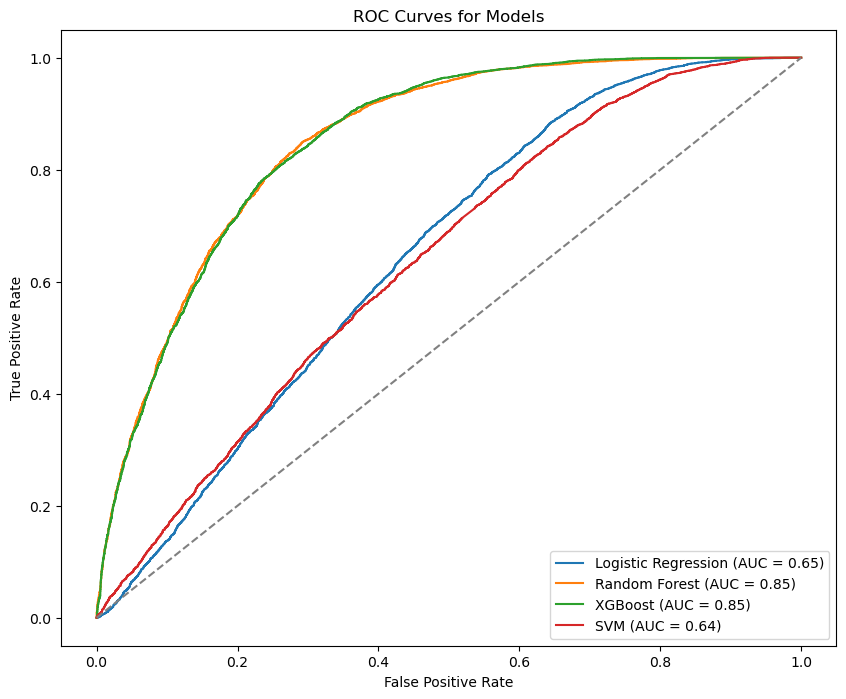

In [67]:
# Dictionary to store the fitted models
fitted_models = {}

# Fit Logistic Regression with balanced class weight
fitted_models["Logistic Regression"] = LogisticRegression(
    class_weight='balanced',
    **results["Logistic Regression"].get('Best Params'),
    random_state=42,
    max_iter=1000
).fit(X_train_res, y_train_res)

# Fit Random Forest with balanced class weight and 300 trees
fitted_models["Random Forest"] = RandomForestClassifier(
    class_weight='balanced',
    **results["Random Forest"].get('Best Params'),
    random_state=42
).fit(X_train_res, y_train_res)

# Fit XGBoost with specified parameters; using hist tree_method for CPU efficiency
fitted_models["XGBoost"] = XGBClassifier(
    scale_pos_weight=1,
    **results["XGBoost"].get('Best Params'),
    random_state=42,
    use_label_encoder=False,
    eval_metric='auc',
    tree_method='hist'
).fit(X_train_res, y_train_res)

# Fit SVM using linear kernel (for faster computation) and enabling probability estimates
fitted_models["SVM"] = SVC(
    class_weight='balanced',
    probability=True,
    random_state=42
).fit(X_train_res, y_train_res)

# Plot ROC curves for each fitted model
plt.figure(figsize=(10, 8))
results_auc = {}  # Dictionary to store AUC for each model

for model_name, model in fitted_models.items():
    # Get predicted probabilities for the positive class
    probs = model.predict_proba(X_test)[:, 1]
    # Compute false positive rate and true positive rate
    fpr, tpr, _ = roc_curve(y_test, probs)
    # Calculate AUC score
    auc = roc_auc_score(y_test, probs)
    results_auc[model_name] = auc
    # Plot ROC curve with a label showing the model name and AUC
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc:.2f})')

# Plot the diagonal reference line for a random classifier
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title('ROC Curves for Models')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

shap_values shape: (12001, 16, 2)
Adjusted SHAP values shape for class 1: (12001, 16)


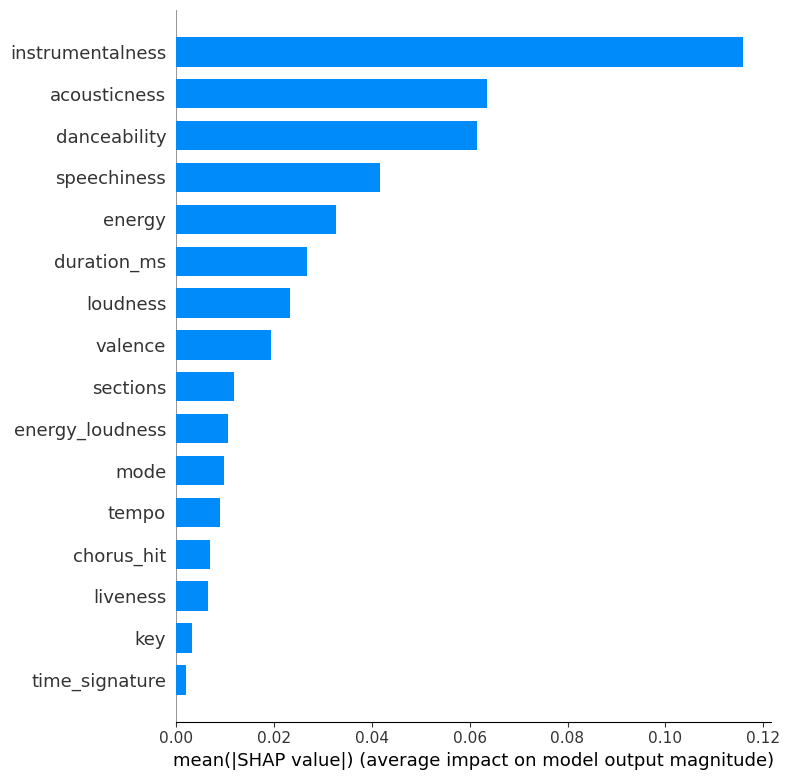

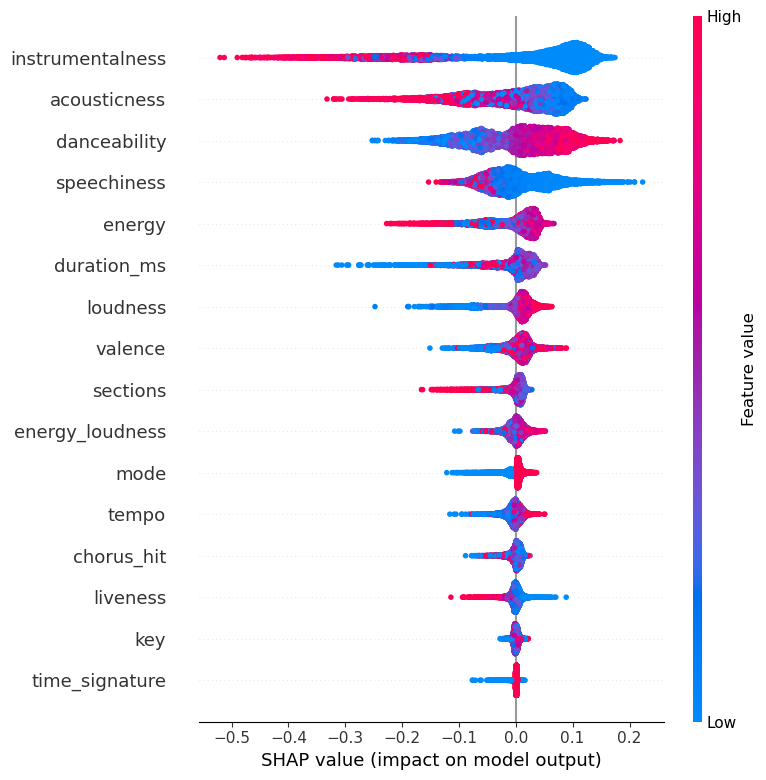

In [ ]:
# Use the same feature matrix that was used to train rf_model
X_for_shap = X_test

# Calculate the SHAP values
explainer = shap.TreeExplainer(fitted_models["Random Forest"])
shap_values = explainer.shap_values(X_for_shap)

# Check the shape of the shap_values:
print("shap_values shape:", shap_values.shape)  # Should print (40003, 15, 2)

# Extract the SHAP values for class 1 (TOP)
# This returns an array with shape (40003, 15)
shap_values_class1 = shap_values[:, :, 1]
print("Adjusted SHAP values shape for class 1:", shap_values_class1.shape)

# Generate the summary plot charts using SHAP values for class 1
shap.summary_plot(shap_values_class1, X_for_shap, plot_type="bar")
shap.summary_plot(shap_values_class1, X_for_shap)


Random Forest Cross-Val AUC: 0.8476707818725142
XGBoost Cross-Val AUC: 0.8479211253107494
Best threshold for F1-score: 0.39, F1-score: 0.698


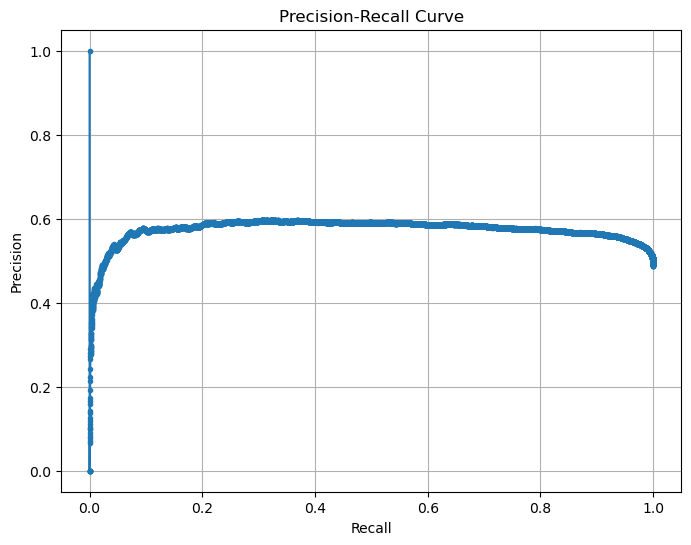

Confusion Matrix:
 [[1676 4463]
 [ 321 5541]]
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.27      0.41      6139
           1       0.55      0.95      0.70      5862

    accuracy                           0.60     12001
   macro avg       0.70      0.61      0.56     12001
weighted avg       0.70      0.60      0.55     12001



In [68]:
# Train models with cross-validation to check for overfitting
rf = RandomForestClassifier(
    class_weight='balanced',
    **results["Random Forest"].get('Best Params'),
    random_state=42
)
xgb = XGBClassifier(
    scale_pos_weight=1,
    **results["XGBoost"].get('Best Params'),
    random_state=42,
    use_label_encoder=False,
    eval_metric='auc',
    tree_method='hist'
)

rf_scores = cross_val_score(rf, X_train, y_train, cv=5, scoring='roc_auc')
xgb_scores = cross_val_score(xgb, X_train, y_train, cv=5, scoring='roc_auc')

print("Random Forest Cross-Val AUC:", np.mean(rf_scores))
print("XGBoost Cross-Val AUC:", np.mean(xgb_scores))

# THRESHOLD TUNING TO MAXIMIZE F1-SCORE USING LOGISTIC REGRESSION

# Train a logistic regression model (as a baseline for threshold tuning)
log_model = LogisticRegression(
    class_weight='balanced',
    **results["Logistic Regression"].get('Best Params'),
    random_state=42,
    max_iter=1000
)
log_model.fit(X_train, y_train)

# Get predicted probabilities for the positive class (class 1)
log_reg_probs = log_model.predict_proba(X_test)[:, 1]

# Define a range of thresholds to test
thresholds = np.linspace(0.1, 0.9, 50)

best_threshold, best_f1 = 0, 0
for t in thresholds:
    preds = (log_reg_probs > t).astype(int)
    f1 = f1_score(y_test, preds)
    if f1 > best_f1:
        best_f1, best_threshold = f1, t

print(f"Best threshold for F1-score: {best_threshold:.2f}, F1-score: {best_f1:.3f}")

# Plot the Precision-Recall curve for logistic regression
precision, recall, _ = precision_recall_curve(y_test, log_reg_probs)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.show()

# Optionally, display confusion matrix and classification report for the best threshold
predictions = (log_reg_probs > best_threshold).astype(int)
print("Confusion Matrix:\n", confusion_matrix(y_test, predictions))
print("Classification Report:\n", classification_report(y_test, predictions))

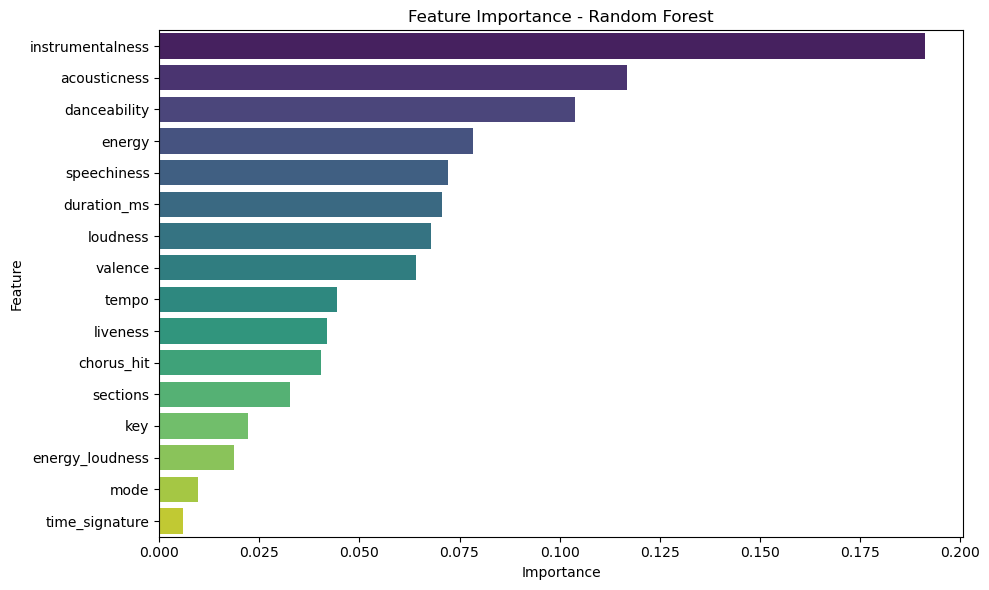

In [70]:
# -----------------------------
# 9. Feature Importance Using Random Forest
# -----------------------------
df_features['energy_loudness'] = X_test['energy'] * X_test['loudness']

features.append('energy_loudness')

rf.fit(df_features[features], df_features['in_top100'])
importances = rf.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, hue = 'Feature', legend = 'auto', palette="viridis")
plt.title("Feature Importance - Random Forest")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
# plt.savefig("feature_importance.png")
plt.show()

In [71]:
# Create additional features for the dataset
df_features = create_features(df_features)

# Split the data into features (X) and target (y)
# We drop the columns 'track', 'Artist', and 'uri' because they are identifiers,
# and 'in_top100' is our target variable.
X = df_features.drop(columns=['track', 'Artist', 'uri', 'in_top100'])
y = df_features['in_top100']

# Split into training and testing sets
X_train_tuning, X_test_tuning, y_train_tuning, y_test_tuning = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# -------------------------------------------
# Additional Hyperparameter Tuning
# -------------------------------------------

# Define hyperparameter grids for Random Forest and XGBoost
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [10, 15],
    'min_samples_split': [2, 5]
}

param_grid_xgb = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.1, 0.05],
    'colsample_bytree': [0.8, 1.0],
    'subsample': [0.8, 1.0]
}

# Initialize GridSearchCV for Random Forest and XGBoost
rf = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid_rf,
    scoring='roc_auc',
    cv=3,
    n_jobs=-1
)
xgb = GridSearchCV(
    XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    param_grid_xgb,
    scoring='roc_auc',
    cv=3,
    n_jobs=-1
)

# Fit the models on the tuning data
rf.fit(X_train_tuning, y_train_tuning)
xgb.fit(X_train_tuning, y_train_tuning)

# Get the best models
best_rf = rf.best_estimator_
best_xgb = xgb.best_estimator_

# Determine the best decision thresholds for each model using the helper function
best_threshold_rf, best_f1_rf = find_best_threshold(best_rf, X_test_tuning, y_test_tuning)
best_threshold_xgb, best_f1_xgb = find_best_threshold(best_xgb, X_test_tuning, y_test_tuning)

# Apply the optimized thresholds to generate predictions
rf_preds = (best_rf.predict_proba(X_test_tuning)[:, 1] >= best_threshold_rf).astype(int)
xgb_preds = (best_xgb.predict_proba(X_test_tuning)[:, 1] >= best_threshold_xgb).astype(int)

# Print the results for Random Forest
print(f"Random Forest - Best Threshold: {best_threshold_rf}, F1-score: {best_f1_rf}")
print(confusion_matrix(y_test_tuning, rf_preds))
print(classification_report(y_test_tuning, rf_preds))

# Print the results for XGBoost
print(f"XGBoost - Best Threshold: {best_threshold_xgb}, F1-score: {best_f1_xgb}")
print(confusion_matrix(y_test_tuning, xgb_preds))
print(classification_report(y_test_tuning, xgb_preds))


Random Forest - Best Threshold: 0.43061224489795913, F1-score: 0.7898665460303099
[[2651 1458]
 [ 400 3492]]
              precision    recall  f1-score   support

           0       0.87      0.65      0.74      4109
           1       0.71      0.90      0.79      3892

    accuracy                           0.77      8001
   macro avg       0.79      0.77      0.77      8001
weighted avg       0.79      0.77      0.76      8001

XGBoost - Best Threshold: 0.4551020408163265, F1-score: 0.7926575848533826
[[2772 1337]
 [ 459 3433]]
              precision    recall  f1-score   support

           0       0.86      0.67      0.76      4109
           1       0.72      0.88      0.79      3892

    accuracy                           0.78      8001
   macro avg       0.79      0.78      0.77      8001
weighted avg       0.79      0.78      0.77      8001



In [54]:
# Previsões no conjunto de treino
# y_pred_rf_train = (rf_model.predict_proba(X_train_tuning)[:, 1] > 0.3).astype(int)
# y_pred_xgb_train = (xgb_model.predict_proba(X_train_tuning)[:, 1] > 0.38).astype(int)

# Aplicação do threshold nos modelos
y_pred_rf_train = (best_rf.predict_proba(X_train_tuning)[:, 1] >= 0.3).astype(int)
y_pred_xgb_train = (best_xgb.predict_proba(X_train_tuning)[:, 1] >= 0.38).astype(int)

print("Random Forest - Treino")
print(classification_report(y_train_tuning, y_pred_rf_train))

print("\nRandom Forest - Teste")
print(classification_report(y_test_tuning, (rf.predict_proba(X_test_tuning)[:, 1] > 0.3).astype(int)))

print("\nXGBoost - Treino")
print(classification_report(y_train_tuning, y_pred_xgb_train))

print("\nXGBoost - Teste")
print(classification_report(y_test_tuning, (xgb.predict_proba(X_test_tuning)[:, 1] > 0.38).astype(int)))

Random Forest - Treino
              precision    recall  f1-score   support

           0       1.00      0.65      0.79     16458
           1       0.73      1.00      0.85     15544

    accuracy                           0.82     32002
   macro avg       0.87      0.83      0.82     32002
weighted avg       0.87      0.82      0.82     32002


Random Forest - Teste
              precision    recall  f1-score   support

           0       0.92      0.54      0.68      4109
           1       0.66      0.95      0.78      3892

    accuracy                           0.74      8001
   macro avg       0.79      0.74      0.73      8001
weighted avg       0.80      0.74      0.73      8001


XGBoost - Treino
              precision    recall  f1-score   support

           0       0.91      0.64      0.75     16458
           1       0.71      0.93      0.81     15544

    accuracy                           0.78     32002
   macro avg       0.81      0.79      0.78     32002
weighted a

In [ ]:
cv_scores_rf = cross_val_score(rf, X_train_tuning, y_train_tuning, cv=5, scoring='f1')
cv_scores_xgb = cross_val_score(xgb, X_train_tuning, y_train_tuning, cv=5, scoring='f1')

print(f"Random Forest - Cross-Validation F1-score: {cv_scores_rf.mean():.3f} ± {cv_scores_rf.std():.3f}")
print(f"XGBoost - Cross-Validation F1-score: {cv_scores_xgb.mean():.3f} ± {cv_scores_xgb.std():.3f}")


Random Forest - Cross-Validation F1-score: 0.779 ± 0.003
XGBoost - Cross-Validation F1-score: 0.780 ± 0.005


# Final Report

In [ ]:

with open("final_report.txt", "w", encoding="utf-8") as f:
    f.write("Music Feature Analysis for TOP Songs\n")
    f.write("====================================\n\n")
    f.write("1. Descriptive Statistics by Group:\n")
    f.write(stats_by_group.to_string())
    f.write("\n\n2. Mann-Whitney U Test p-values:\n")
    f.write(p_values_df.to_string(index=False))
    f.write("\n\n3. ANOVA Test p-values:\n")
    f.write(anova_results_df.to_string(index=False))
    f.write("\n\n4. Observations:\n")
    f.write("   - The musical features, although informative, do not fully explain song popularity due to external factors (e.g., marketing, cultural trends).\n")
    f.write("   - Certain features (see feature importance plot) are more influential in distinguishing TOP songs, yet inherent variability remains.\n")
    f.write("   - Consider incorporating contextual data to further enhance the model.\n")
    
print("Final report and all plots have been saved.")

Final report and all plots have been saved.


# Notas